#### Bibliotecas básicas

In [12]:
import pandas as pd
import re

#### Bibliotecas relacionadas a preparação dos dados

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#### Bibliotecas relacionadas aos modelos

In [37]:
from keras.utils import np_utils
from keras.layers import Dense, Input, Activation, Conv1D
from keras.layers import Dropout, MaxPooling1D, Flatten, Concatenate, Reshape
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

#### Bibliotecas relacionadas aos gráficos

In [41]:
import matplotlib.pyplot as plt

#### Carregando dataset de treino

In [2]:
train_df = pd.read_json("../datasets/cooking/train.json")

#### Vizualizando alguns dados

In [3]:
train_df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


#### Carregando dataset de teste

In [4]:
test_df = pd.read_json("../datasets/cooking/test.json")

#### Vizualizando dados

In [5]:
test_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


#### Concatenando os dois datasets

In [7]:
test_df["cuisine"] = "unknown"
df = pd.concat([train_df, test_df], ignore_index=True)

#### Vizualizando dados

In [8]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [10]:
df.shape

(49718, 3)

#### TF-IDF

#### Convertendo palavras com letras maiúsculas em minúsculas

In [11]:
df.ingredients = df.ingredients.apply(lambda x: (" ".join(x)).lower())

#### Removendo caracteres especiais

In [14]:
df.ingredients = df.ingredients.apply(lambda x: re.sub(r'[^\w\d ,]', '', x))

#### Vizualizando dados

In [15]:
df.head()

,id,cuisine,ingredients
0,10259,greek,romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,plain flour ground pepper salt tomatoes ground...
2,20130,filipino,eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallots cornflour cayenne pepper...


In [16]:
train_set = df[df.cuisine != 'unknown']
test_set = df[df.cuisine == 'unknown']

In [20]:
tfidf = TfidfVectorizer(binary=True)
x = tfidf.fit_transform(train_set.ingredients).todense()
x_test = tfidf.transform(test_set.ingredients).todense()

In [22]:
x.shape

(39774, 3073)

In [25]:
x_test.shape

(9944, 3073)

#### Dividindo dataset de treino

In [32]:
lb = LabelEncoder()
y = lb.fit_transform(train_set.cuisine)
y = np_utils.to_categorical(y)

In [33]:
y.shape

(39774, 20)

In [35]:
seed = 29
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=seed)

In [36]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((31819, 3073), (31819, 20), (7955, 3073), (7955, 20))

#### MLP

In [39]:
MLP = Sequential()
MLP.add(Dense(512, input_shape=(3073, ), activation='relu'))
MLP.add(Dropout(0.5))
MLP.add(Dense(y_train.shape[1], activation='softmax'))
MLP.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
MLP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               1573888   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 20)                10260     
                                                                 
Total params: 1,584,148
Trainable params: 1,584,148
Non-trainable params: 0
_________________________________________________________________


In [43]:
file_weights_path = "../datasets/cooking/weights/mlp.hdf5"
check_point = ModelCheckpoint(filepath=file_weights_path, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
early_stop = EarlyStopping(monitor="val_acc", mode="max", patience=5)

mlp_history = MLP.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[check_point, early_stop]
)

2023-06-01 00:42:30.054630: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 391119148 exceeds 10% of free system memory.


Epoch 1/50
248/249 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9288

2023-06-01 00:42:46.880297: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 97782860 exceeds 10% of free system memory.


249/249 [==============================] - 11s 44ms/step - loss: 0.2339 - accuracy: 0.9289 - val_loss: 0.7687 - val_accuracy: 0.7892
Epoch 2/50
249/249 [==============================] - 10s 40ms/step - loss: 0.2227 - accuracy: 0.9336 - val_loss: 0.7829 - val_accuracy: 0.7915
Epoch 3/50
249/249 [==============================] - 14s 56ms/step - loss: 0.2102 - accuracy: 0.9378 - val_loss: 0.7939 - val_accuracy: 0.7882
Epoch 4/50
249/249 [==============================] - 44s 176ms/step - loss: 0.2024 - accuracy: 0.9389 - val_loss: 0.8006 - val_accuracy: 0.7892
Epoch 5/50
249/249 [==============================] - 52s 210ms/step - loss: 0.1902 - accuracy: 0.9435 - val_loss: 0.8137 - val_accuracy: 0.7887
Epoch 6/50
249/249 [==============================] - 42s 168ms/step - loss: 0.1809 - accuracy: 0.9467 - val_loss: 0.8268 - val_accuracy: 0.7908
Epoch 7/50
249/249 [==============================] - 20s 81ms/step - loss: 0.1667 - accuracy: 0.9512 - val_loss: 0.8329 - val_accuracy: 0.7891


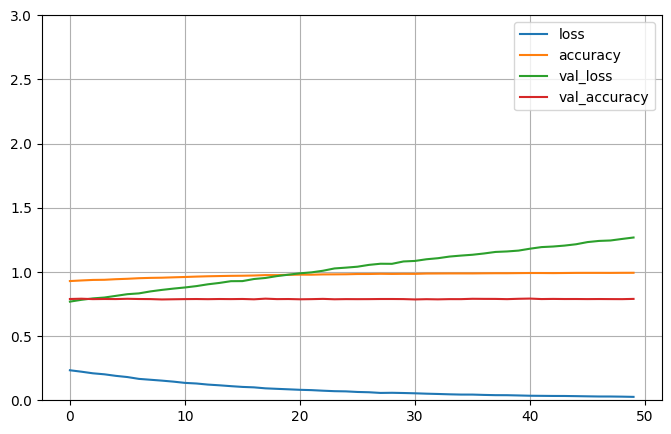

In [44]:
pd.DataFrame(mlp_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
plt.show()